# Predicting the Programming Languages of Most Starred Github Repos

## Goal
Build a model that can predict what programming language a repository is, given the text of the README file.

In [137]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import os
import acquire
import prepare

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

## I. Acquire

Fetch data from local cache using the function `scrape_github_data` from the acquire.py module.

In [2]:
#acquire.scrape_github_data()

In [27]:
df = pd.read_json('prepped15_df.json')

## II. Prep

`prep_articles` function from the prepare.py module performs the following:
 - normalize data by removing non-ascii characters, special characters, numbers, white spaces...
 - tokenize words
 - stem and lemmatize words
 - remove stop words and other extraneous words

What are the words we want to exclude?
- http
- banner
- request
- img
- badge
- svg
- www
- com
- png
- welcome
- pr
- style
- flat
- makeapullrequest
- gitpod
- logo
- blue
- green
- brightgreen
- div
- align
- center
- width
- src

Look for documents where there are no programming language indicated.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 99
Data columns (total 6 columns):
language      504 non-null object
original      504 non-null object
normalized    504 non-null object
stemmed       504 non-null object
lemmatized    504 non-null object
cleaned       504 non-null object
dtypes: object(6)
memory usage: 27.6+ KB


## III. Explore

Extract a separate data frame called `dfx` that will be used for exploration. We will only focus on the target variable `language` and the feature variable `cleaned` which contains the content of the readme files.

Below are the questions we want to answer in this phase:
1. What are the most common words in READMEs?
2. What does the distribution of IDFs look like for the most common words?
3. Does the length of the README vary by programming language?
4. Do different programming languages use a different number of unique words?

In [31]:
dfx = df[["language","cleaned"]]

In [32]:
dfx.head()

,language,cleaned
0,Python,bert new may whole word masking model release ...
10,Python,align center cdn rawgit jarun googler master g...
100,Ruby,imgur felxx xcpretty fast flexible formatter x...
101,Go,command line tool installing using jenkins jen...
102,JavaScript,align center table colgroup col width colgroup...


In [33]:
df.language.value_counts()

JavaScript          129
Python               83
Java                 47
PHP                  40
Go                   37
Jupyter Notebook     25
HTML                 23
Swift                22
TypeScript           20
Ruby                 18
C++                  16
CSS                  15
Shell                12
C                     9
C#                    8
Name: language, dtype: int64

### Look at Lengths of README files by Language

In [34]:
df_len = dfx.assign(length = dfx.cleaned.apply(len))

In [35]:
df_len.head()

,language,cleaned,length
0,Python,bert new may whole word masking model release ...,28440
10,Python,align center cdn rawgit jarun googler master g...,14023
100,Ruby,imgur felxx xcpretty fast flexible formatter x...,2395
101,Go,command line tool installing using jenkins jen...,6025
102,JavaScript,align center table colgroup col width colgroup...,2694


In [43]:
df_len[df_len['language'] == 'JavaScript']['length'].sort_values(ascending=False)

183    140406
205     93273
13      57923
186     48400
120     48400
208     48333
215     42689
281     24971
63      14415
527     14415
57      14269
557     14082
97      13053
534     12839
391     12397
52      12307
43      11975
633     11889
5       10507
528     10193
67      10193
659      9487
638      8857
240      8666
560      7842
508      7682
437      7663
177      7531
661      7500
570      6921
        ...  
56       1283
66       1263
498      1260
472      1237
516      1212
407      1182
12       1022
484       945
16        938
524       931
382       791
31        727
398       723
523       700
492       696
425       694
344       655
35        625
671       595
504       547
6         540
510       506
211       488
440       460
486       411
221       184
213       170
233       122
17         87
234        50
Name: length, Length: 129, dtype: int64

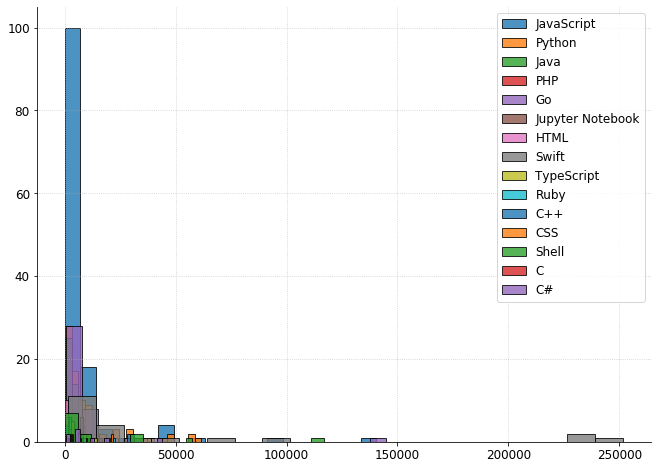

In [40]:
languages = ['JavaScript', 'Python', 'Java', 'PHP', 'Go', 'Jupyter Notebook', 
             'HTML', 'Swift', 'TypeScript', 'Ruby', 'C++', 'CSS', 'Shell',
             'C', 'C#']

bins = 20
for lang in languages:
    plt.hist(df_len[df_len['language'] == lang]['length'], bins=bins, alpha=0.8, label=lang)
    
plt.legend()
plt.show()

In [52]:
# bins = 20
# plt.hist(df_len[df_len['language'] == 'JavaScript']['length'], bins=bins, alpha=0.8, label='JavaScript')
# plt.hist(df_len[df_len['language'] == 'Python']['length'], bins=bins, alpha=0.8, label='Python')
# plt.hist(df_len[df_len['language'] == 'Java']['length'], bins=bins, alpha=0.8, label='Java')
# plt.hist(df_len[df_len['language'] == 'TypeScript']['length'], bins=bins, alpha=0.8, label='TypeScript')

# plt.legend()
# plt.title('Length of README Files by Language')
# plt.show()

#### A. Distribution of Data, Top Words

In [53]:
value_counts = pd.DataFrame(dfx.language.value_counts(ascending=False))
value_counts

,language
JavaScript,129
Python,83
Java,47
PHP,40
Go,37
Jupyter Notebook,25
HTML,23
Swift,22
TypeScript,20
Ruby,18


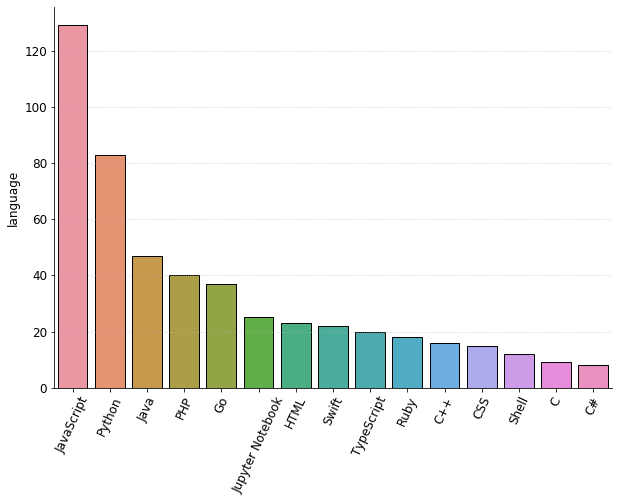

In [54]:
plt.figure(figsize=(10,7))
bar = sns.barplot(x=value_counts.index, y="language", data=value_counts)
bar.set_xticklabels(bar.get_xticklabels(),rotation=65)

plt.show()

#### Value Counts and Percentages for Language

In [55]:
pd.concat(
    [dfx.language.value_counts(), dfx.language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
JavaScript,129,0.255952
Python,83,0.164683
Java,47,0.093254
PHP,40,0.079365
Go,37,0.073413
Jupyter Notebook,25,0.049603
HTML,23,0.045635
Swift,22,0.043651
TypeScript,20,0.039683
Ruby,18,0.035714


### Term Frequency

In [65]:
raw_count_js = pd.Series(' '.join(df[df.language=='JavaScript']['cleaned']).split()).value_counts()
raw_count_p = pd.Series(' '.join(df[df.language=='Python']['cleaned']).split()).value_counts()
raw_count_j = pd.Series(' '.join(df[df.language=='Java']['cleaned']).split()).value_counts()
raw_count_php = pd.Series(' '.join(df[df.language=='PHP']['cleaned']).split()).value_counts()
raw_count_go = pd.Series(' '.join(df[df.language=='Go']['cleaned']).split()).value_counts()
raw_count_jup = pd.Series(' '.join(df[df.language=='Jupyter Notebook']['cleaned']).split()).value_counts()
raw_count_html = pd.Series(' '.join(df[df.language=='HTML']['cleaned']).split()).value_counts()
raw_count_swift = pd.Series(' '.join(df[df.language=='Swift']['cleaned']).split()).value_counts()
raw_count_ts = pd.Series(' '.join(df[df.language=='TypeScript']['cleaned']).split()).value_counts()
raw_count_rub = pd.Series(' '.join(df[df.language=='Ruby']['cleaned']).split()).value_counts()
raw_count_cp = pd.Series(' '.join(df[df.language=='C++']['cleaned']).split()).value_counts()
raw_count_css = pd.Series(' '.join(df[df.language=='CSS']['cleaned']).split()).value_counts()
raw_count_shell = pd.Series(' '.join(df[df.language=='Shell']['cleaned']).split()).value_counts()
raw_count_c = pd.Series(' '.join(df[df.language=='C']['cleaned']).split()).value_counts()
raw_count_csharp = pd.Series(' '.join(df[df.language=='C#']['cleaned']).split()).value_counts()

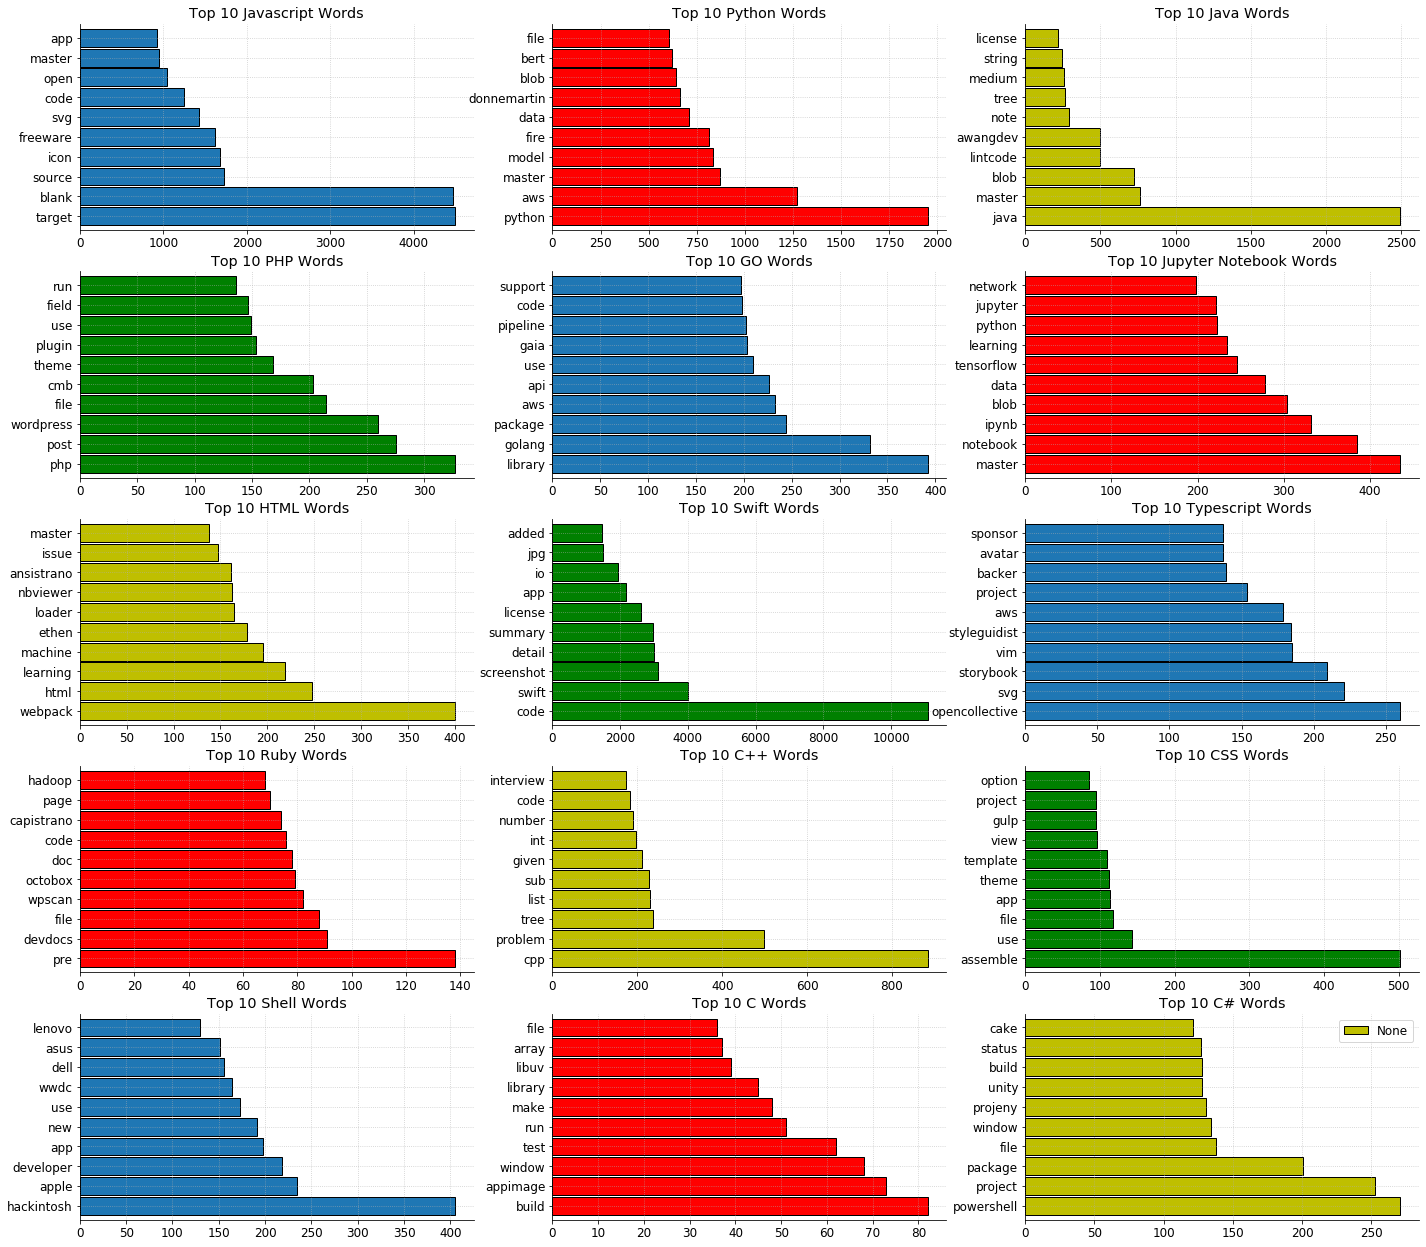

In [78]:
plt.figure(figsize=(24,22))

subplot(5,3,1)
raw_count_js.sort_values(ascending=False)[0:10].plot.barh(width=.9)
title('Top 10 Javascript Words')

subplot(5, 3, 2)
raw_count_p.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
title('Top 10 Python Words')

subplot(5, 3, 3)
raw_count_j.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
title('Top 10 Java Words')

subplot(5, 3, 4)
raw_count_php.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='g')
title('Top 10 PHP Words')


subplot(5, 3, 5)
raw_count_go.sort_values(ascending=False)[0:10].plot.barh(width=.9)
title('Top 10 GO Words')


subplot(5, 3, 6)
raw_count_jup.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
title('Top 10 Jupyter Notebook Words')


subplot(5, 3, 7)
raw_count_html.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
title('Top 10 HTML Words')


subplot(5, 3, 8)
raw_count_swift.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='g')
title('Top 10 Swift Words')


subplot(5, 3, 9)
raw_count_ts.sort_values(ascending=False)[0:10].plot.barh(width=.9)
title('Top 10 Typescript Words')

subplot(5, 3, 10)
raw_count_rub.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
title('Top 10 Ruby Words')


subplot(5, 3, 11)
raw_count_cp.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
title('Top 10 C++ Words')


subplot(5, 3, 12)
raw_count_css.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='g')
title('Top 10 CSS Words')


subplot(5, 3, 13)
raw_count_shell.sort_values(ascending=False)[0:10].plot.barh(width=.9)
title('Top 10 Shell Words')


subplot(5, 3, 14)
raw_count_c.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
title('Top 10 C Words')


subplot(5, 3, 15)
raw_count_csharp.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
title('Top 10 C# Words')

plt.legend()
plt.show()

In [79]:
# subplot(2,2,1)
# raw_count_js.sort_values(ascending=False)[0:10].plot.barh(width=.9)
# title('Top 10 Javascript Words')

# subplot(2,2,2)
# raw_count_p.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='r')
# title('Top 10 Python Words')

# subplot(2,2,3)
# raw_count_j.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='y')
# title('Top 10 Java Words')

# subplot(2,2,4)
# raw_count_ts.sort_values(ascending=False)[0:10].plot.barh(width=.9, color='g')
# title('Top 10 Typescript Words')

# suptitle('Top 10 Words in README Files by Language')

# plt.show()

In [80]:
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()

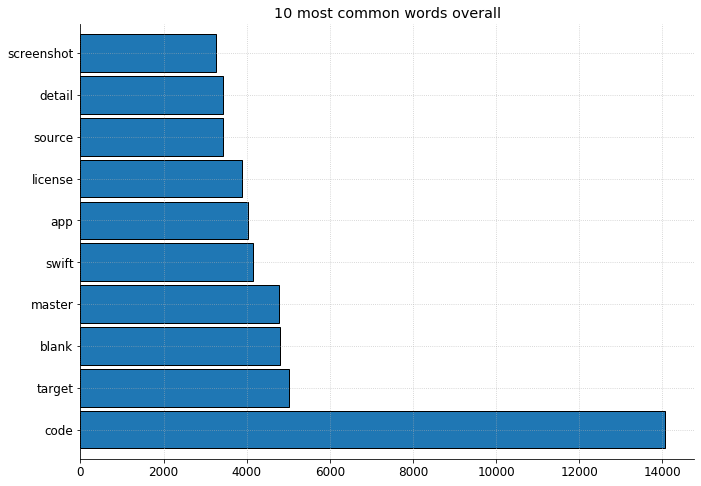

In [81]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words overall')

plt.show()

### Frequency of Words by Language Subsets

In [87]:
languages

['JavaScript',
 'Python',
 'Java',
 'PHP',
 'Go',
 'Jupyter Notebook',
 'HTML',
 'Swift',
 'TypeScript',
 'Ruby',
 'C++',
 'CSS',
 'Shell',
 'C',
 'C#']

In [88]:
js_words = ' '.join(dfx[dfx.language == 'JavaScript'].cleaned).split()

In [89]:
p_words = ' '.join(dfx[dfx.language == 'Python'].cleaned).split()

In [90]:
j_words = ' '.join(dfx[dfx.language == 'Java'].cleaned).split()

In [91]:
php_words = ' '.join(dfx[dfx.language == 'PHP'].cleaned).split()

In [92]:
go_words = ' '.join(dfx[dfx.language == 'Go'].cleaned).split()

In [93]:
jup_words = ' '.join(dfx[dfx.language == 'Jupyter Notebook'].cleaned).split()

In [94]:
html_words = ' '.join(dfx[dfx.language == 'HTML'].cleaned).split()

In [95]:
swift_words = ' '.join(dfx[dfx.language == 'Swift'].cleaned).split()

In [96]:
ts_words = ' '.join(dfx[dfx.language == 'TypeScript'].cleaned).split()

In [97]:
ruby_words = ' '.join(dfx[dfx.language == 'Ruby'].cleaned).split()

In [104]:
cp_words = ' '.join(dfx[dfx.language == 'C++'].cleaned).split()

In [105]:
css_words = ' '.join(dfx[dfx.language == 'CSS'].cleaned).split()

In [106]:
shell_words = ' '.join(dfx[dfx.language == 'Shell'].cleaned).split()

In [107]:
c_words = ' '.join(dfx[dfx.language == 'C'].cleaned).split()

In [108]:
cs_words = ' '.join(dfx[dfx.language == 'Shell'].cleaned).split()

In [103]:
all_words = ' '.join(dfx.cleaned).split()

### Explore Frequency of Subsets by Language

In [109]:
js_freq = pd.Series(js_words).value_counts()

In [110]:
p_freq = pd.Series(p_words).value_counts()

In [111]:
j_freq = pd.Series(j_words).value_counts()

In [112]:
php_freq = pd.Series(php_words).value_counts()

In [113]:
go_freq = pd.Series(go_words).value_counts()

In [114]:
jup_freq = pd.Series(jup_words).value_counts()

In [115]:
html_freq = pd.Series(html_words).value_counts()

In [116]:
swift_freq = pd.Series(swift_words).value_counts()

In [117]:
ts_freq = pd.Series(ts_words).value_counts()

In [118]:
ruby_freq = pd.Series(ruby_words).value_counts()

In [120]:
cp_freq = pd.Series(cp_words).value_counts()

In [121]:
css_freq = pd.Series(css_words).value_counts()

In [122]:
shell_freq = pd.Series(shell_words).value_counts()

In [123]:
c_freq = pd.Series(c_words).value_counts()

In [124]:
cs_freq = pd.Series(cs_words).value_counts()

In [125]:
all_freq = pd.Series(all_words).value_counts()

### Combine Series' together into df

In [136]:
word_counts = (pd.concat([all_freq, js_freq, p_freq, j_freq, php_freq, go_freq, jup_freq, html_freq, swift_freq, ts_freq, ruby_freq, cp_freq, css_freq, c_freq, cs_freq], axis=1, sort=True)
 .set_axis(['all', 'javascript', 'python', 'java', 'php', 'go', 'jupyter_notebook', 'html', 'swift', 'typescript', 'ruby', 'C+', 'CSS', 'C', 'C#'], axis=1, inplace=False)
 .fillna(0)
 .apply(lambda s: s.astype(int)))

word_counts.head(100)

,all,javascript,python,java,php,go,jupyter_notebook,html,swift,typescript,ruby,C+,CSS,C,C#
aaa,12,0,0,0,1,0,1,0,10,0,0,0,0,0,0
aaaa,4,0,2,0,0,0,0,0,0,0,0,2,0,0,0
aaaaaaaaaaaa,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
aaaaaaaaaaaaaaaaaaaa,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0
aaaaaaaaaaaaaaaaaaaaa,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
aaaaj,4,0,4,0,0,0,0,0,0,0,0,0,0,0,0
aaafj,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
aaai,4,0,0,0,0,0,4,0,0,0,0,0,0,0,0
aab,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
aabac,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### Most Frequently Occuring Words

In [130]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python,java,php,go,jupyter_notebook,html,swift,typescript,ruby,C+,CSS,C,C#
code,14063,1251,522,94,68,198,151,81,11080,135,76,183,68,14,108
target,5016,4496,113,26,18,65,25,5,38,128,25,26,9,3,24
blank,4794,4467,56,11,17,46,14,1,17,127,18,2,3,1,1
master,4778,954,868,761,87,107,435,138,979,76,24,145,29,12,116
swift,4157,20,9,41,0,4,1,1,4015,1,1,0,0,0,64
app,4032,928,241,50,61,38,0,50,2172,91,45,21,114,6,198
license,3898,319,249,218,93,86,39,47,2600,49,52,27,33,22,33
source,3433,1733,209,60,37,102,24,20,1031,25,25,27,40,14,46
detail,3426,84,89,19,33,23,23,15,2986,15,11,34,37,6,24
screenshot,3260,73,1,13,19,15,0,3,3105,1,3,3,12,0,8


### Explore Words Unique to Languages

#### Python Keywords

In [131]:
word_counts[word_counts.javascript == 0].sort_values(by='python', ascending=False)

,all,javascript,python,java,php,go,jupyter_notebook,html,swift,typescript,ruby,C+,CSS,C,C#
donnemartin,716,0,665,0,0,0,49,0,0,0,0,0,0,0,2
ipynb,863,0,438,0,0,10,332,82,0,0,0,0,1,0,0
nbviewer,742,0,436,0,0,6,137,162,1,0,0,0,0,0,0
mnist,275,0,254,0,0,0,21,0,0,0,0,0,0,0,0
epoch,242,0,240,0,0,0,1,0,0,0,1,0,0,0,0
train,216,0,193,0,0,0,18,2,0,1,0,0,0,0,2
awslabs,191,0,189,0,0,0,0,0,0,2,0,0,0,0,0
pypi,197,0,184,0,0,1,6,0,1,1,0,0,4,0,0
squad,176,0,176,0,0,0,0,0,0,0,0,0,0,0,0
panda,245,0,160,0,0,1,72,8,2,0,0,0,2,0,0


#### Javascript Keywords

In [132]:
word_counts[word_counts.python == 0].sort_values(by='javascript', ascending=False)


,all,javascript,python,java,php,go,jupyter_notebook,html,swift,typescript,ruby,C+,CSS,C,C#
freeware,1619,1619,0,0,0,0,0,0,0,0,0,0,0,0,0
os,545,516,0,10,0,4,0,0,6,4,1,4,0,0,0
lisadziuba,451,450,0,0,0,0,0,0,1,0,0,0,0,0,0
strider,235,235,0,0,0,0,0,0,0,0,0,0,0,0,0
spencermountain,217,217,0,0,0,0,0,0,0,0,0,0,0,0,0
observablehq,211,211,0,0,0,0,0,0,0,0,0,0,0,0,0
agpl,159,135,0,2,0,1,0,0,20,1,0,0,0,0,0
lando,117,117,0,0,0,0,0,0,0,0,0,0,0,0,0
colspan,125,117,0,0,0,0,8,0,0,0,0,0,0,0,0
shipit,110,110,0,0,0,0,0,0,0,0,0,0,0,0,0


### Create Corpus

Make a variable named `corpus`, which is a pd.Series of all the words in `dfx`. Correspondingly, make a variable named `bag` (i.e., "bag of words") which provides us with a list of all words in one big collection.

In [120]:
corpus = pd.Series(" ".join(dfx.cleaned).split())
bag = " ".join(dfx.cleaned)

(-0.5, 399.5, 199.5, -0.5)

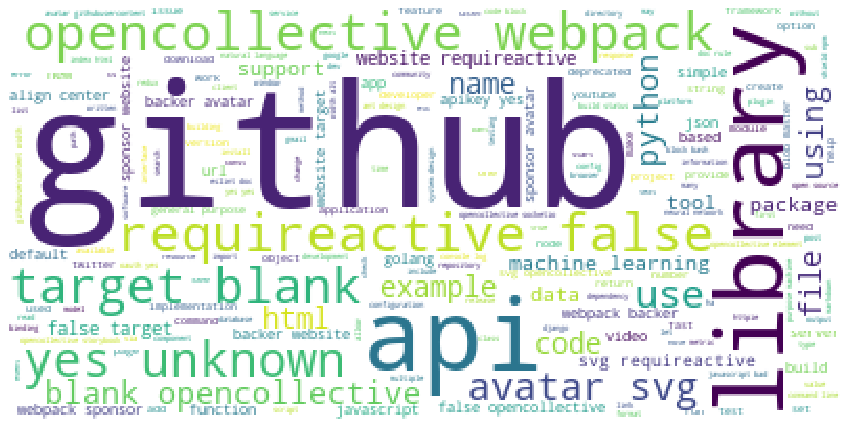

In [121]:
plt.figure(figsize=(15, 8))
img = WordCloud(background_color='white',random_state=1).generate(bag)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

### C. Common Bigrams

### TF-IDF with Scikit-Learn

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [147]:
documents = df.cleaned.to_dict()

In [148]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(documents.values())

In [149]:
features_df = pd.DataFrame(X.todense(), columns=tfidf.get_feature_names())
features_df.head()

,aaa,aaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaaj,aaafj,aaai,aab,aabac,...,zybuluo,zydeco,zydis,zypper,zysuper,zyszys,zythum,zythumbnailtableview,zzan,zzmark
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.006662,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
y = df.language

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

dt = DecisionTreeClassifier(criterion='entropy', splitter='best',
                           max_depth=None, min_samples_split=8,
                           min_samples_leaf=4,
                           random_state=123).fit(X_train, y_train)

train['predicted'] = dt.predict(X_train)
test['predicted'] = dt.predict(X_test)

In [152]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 77.42%
---
Confusion Matrix
actual            C  C#  C++  CSS  Go  HTML  Java  JavaScript  \
predicted                                                       
C                 5   0    1    0   2     1     1           1   
C#                0   4    0    2   0     0     0           0   
C++               0   1   10    1   0     0     1           0   
CSS               0   0    0    8   0     1     0           2   
Go                0   0    1    0  22     1     1           0   
HTML              1   0    1    0   0     9     0           3   
Java              1   0    0    0   2     1    34           0   
JavaScript        0   0    0    0   1     2     0          92   
Jupyter Notebook  0   1    0    0   0     1     0           0   
PHP               0   0    0    0   1     1     1           0   
Python            0   0    0    1   1     1     0           1   
Ruby              0   0    0    0   0     0     0           0   
Shell             0   0    0    0   1     0     0   

In [153]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 36.63%
---
Confusion Matrix
actual            C  C#  C++  CSS  Go  HTML  Java  JavaScript  \
predicted                                                       
C                 1   0    0    0   0     0     0           2   
C#                0   0    0    0   0     1     0           0   
C++               0   2    0    0   0     0     0           1   
CSS               0   0    0    0   0     1     0           1   
Go                1   0    2    0   4     0     2           0   
HTML              0   0    0    1   0     0     1           6   
Java              0   0    0    0   0     0     5           3   
JavaScript        0   0    0    1   1     0     1           9   
Jupyter Notebook  0   0    1    0   0     1     0           0   
PHP               0   0    0    0   0     1     0           1   
Python            0   0    0    1   1     0     0           1   
Shell             0   0    0    0   1     1     0           0   
Swift             0   0    0    0   0     0     0   

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
